In [1]:
import matplotlib.pyplot as pl
import numpy as np
import random
import qnm_filter
import qnm
import random

In [2]:
mmax = 8.4 * 1e-21

In [13]:
def signal_creator():
    # Creates a waveform 
    global signal, signal220, signal330, t_range, mass, injected
    mass_in_solar = 100
    chi_inject = 0.4
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0]) # converts between time in M and seconds
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega330 = qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected[1])[0]

    mmax = 8.4 * 1e-21 #Normalisation factor useful for colored noise injections
    phase1 = 0
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = 0
    A330x = mmax*np.cos(phase2)
    A330y = mmax*np.sin(phase2)

    amp_frac = 0.5
    amp220 = amp_frac
    amp330 = 1-amp_frac

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal330 = np.real(amp330 * (A330x + 1j * A330y) * np.exp(-1j * omega330 * np.abs(t_range / mass)))
  
    signal = signal220+signal330

In [14]:
def injection_evidence(acf_scale):
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=3*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', remove_mean=False)
    fit.compute_acfs('original_data')
    temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
    temp_acf[0] = (mmax)**2*acf_scale
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    fit.add_filter(mass = injected[0], chi = injected[1], model_list = [(2,2,0,'p')])
    template = fit.truncate_data(fit.filtered_data)['H1']
    SNR330_res = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal330, index=t_range)
    fit.condition_data('original_data', remove_mean=False)
    template = fit.truncate_data(fit.original_data)['H1']
    SNR330 = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal220+signal330, index=t_range)
    fit.condition_data('original_data', remove_mean=False)
    template = fit.truncate_data(fit.original_data)['H1']
    SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
    return np.array([SNRtot, SNR330_res, SNR330])

In [20]:
noise_space = np.power(np.linspace(3e0, 5e1, 50), -2) #np.power(np.logspace(-2.5, -2, 150),2)
temp_arr = []

for i in noise_space:
    signal_creator()
    temp_arr.append(injection_evidence(i))

temp_arr = np.asarray(temp_arr)

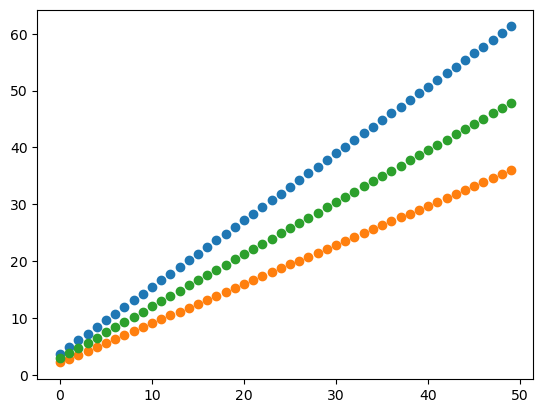

In [21]:
pl.plot(temp_arr, 'o')
# pl.ylim(0, 30)

(array([16.,  8., 11.,  2.,  4.,  4.,  0.,  4.,  0.,  1.]),
 array([ 0.05215094,  3.68747826,  7.32280557, 10.95813288, 14.5934602 ,
        18.22878751, 21.86411482, 25.49944214, 29.13476945, 32.77009676,
        36.40542407]),
 <BarContainer object of 10 artists>)

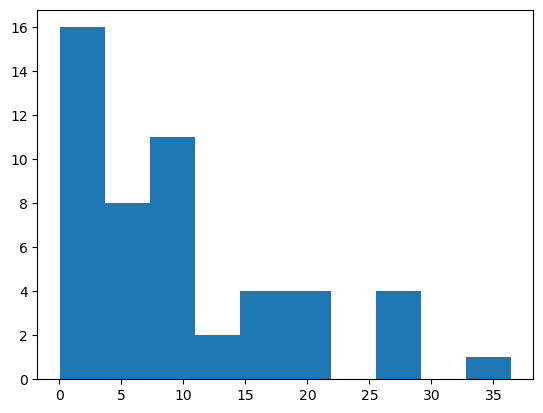

In [44]:
pl.hist(temp_arr)